In [1]:
# -*- coding: utf-8 -*-

import netCDF4 as nc4
import numpy as np
import time, sys, os

# one way to do
# sys.path.append(os.path.abspath('vacumm-3.4.0/'))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator, FixedFormatter,
                               NullLocator)
import matplotlib.gridspec as gridspec

import matplotlib.animation as animation
# from pylab import *
# import cmocean
import types


In [2]:

""" *****************************************************************
"""

# ########################################################
#
#dir  = "/Users/gm/Documents/nemo/release-4.0.1/tests/my_overflow/EXP_sanity/abp1e-4_smt3/"
#dirm = "/Users/gm/Documents/nemo/release-4.0.1/tests/my_overflow/EXP_sanity/abp1e-4_smt3/"

#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_ref_zps_default_noslip"
#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_ref_zps_default"
#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_ref_zps_fct22ubs"
#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_ref_zps_fct44ubs"
#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_ref_sco_default"

#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_bvp_msk_1e-4_fsp_imp12"
#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_bvp_msk_1e-1_fsp_imp12"

#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_bvp_smo1_1e-2_fsp_imp12"
#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_bvp_smo3_1e-3_fsp_imp12"
#workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_bvp_smo3_1e-2_fsp_imp12"

workdir  = "/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_up1/moy_phimin0001_smo6"

dirm = workdir
pdt = workdir +"/OVF_grid_T.nc"
pdu = workdir +"/OVF_grid_U.nc"

pmm = dirm+"/mesh_mask.nc"

save = 1 ; psave = workdir.split("/")[-1]
film = 1 ; bvp = False ; zps = True
nt = -1  ; tskip=1
dpi = 300

vmin = 10 ; vmax = 20 ; timeframe = "30min"
Ncolor=10
dv=(vmax-vmin)/Ncolor


"""
    Plot du test overflow - zps : z partial cells
    34 : time step
    101 : depth (z)
    3 : y dimension (1 cell embraced by two boundary layers)
    202 : x dimension
"""
dt = nc4.Dataset(pdt)

toce = dt.variables['thetao_inst'][::tskip,:,:,:]   # volumic transport
nT,nK,nJ,nI = np.shape(toce)
mm = nc4.Dataset(pmm)

tmask = mm.variables['tmask'][0][:,:,:]
glamt = mm.variables['glamt'][0] ; gphit = mm.variables['gphit'][0]
glamu = mm.variables['glamu'][0]
umask = mm.variables['umask'][0] ; vmask = mm.variables['vmask'][0]
gdept = mm.variables['gdept_0'][0] ; gdepw = mm.variables['gdepw_0'][0]
e3w = mm.variables['e3w_0'][0]
mbathy= mm.variables['mbathy'][0,:,:]


print("domain size is (x,y) %dx%d with %d k-levels" % (nI,nJ,nK))
midY = 1
# middle = 3

if bvp :
    rpot = dt.variables['rpot'][-1,:,1,:]
    abp = np.min(rpot)
    du = nc4.Dataset(pdu)
    rpou = du.variables['rpou'][-1,:,1,:]


#######################################################
# s coordinate is painful
# density points are T points
yt = np.zeros((nK,nI))
yt[:,:] = gdept[:,midY,:]
xt = yt*0. ; x1t = glamt[midY,:]
for k in range(nK):
    xt[k,:]=x1t

# ... surrounded by UW points
yw = np.zeros((nK+1,nI+1))
yw[:-1,1:] = gdepw[:,midY,:] ; zbot = gdepw[-1,midY,:] + 2.*(gdept[-1,midY,:] - gdepw[-1,midY,:])
yw[:-1,0 ] = gdepw[:,midY,0] ; yw[-1,1:] = zbot ;  yw[-1,0] = zbot[0]
yuw= yw*0.
for i in range(0,nI):
    yuw[:,i]=0.5*( yw[:,i] + yw[:,i+1] )

xu = yw*0. ; dx=2*(glamu[0,0]-glamt[0,0])
for k in range(nK+1):
    xu[k,1:]=glamu[midY,:]
xu[:,0] = xu[:,1] - dx

########################################################
# to have a look at the meshmask
# first bottom cell (masked - task[mbathy,:,:]-> 0)

f =  (  500. + 0.5 * 1500. * ( 1.0 + np.tanh( (glamt[1,:] - 40.) / 7. ) )  )

zht = np.copy(glamt[1,:])*0.
for ji in range(nI):
    dist = 2000.
    for jk in range(nK):
        if (np.abs(f[ji] - gdepw[jk,1,ji]) < dist ) :
            jkref = jk
        dist = np.abs(f[ji] - gdepw[jk, 1,ji])
    zht[ji] = gdepw[jkref,1,ji]

########################################################
# masking density points
temp = np.zeros((nT,nK,nI)) ; bigmask = 1-np.repeat(tmask[np.newaxis,:,1,:],nT,axis=0)
temp[:] = toce[:,:,1,:]
temp = np.ma.array(temp,mask=bigmask)
########################################################

dt.close()
mm.close()

FileNotFoundError: [Errno 2] No such file or directory: b'/gpfswork/rech/omr/ukd13rj/nemo/penalnemov4.0.1/tests/penaloverflow/exp_up1/moy_phimin0001_smo6/mesh_mask.nc'

NameError: name 'xu' is not defined

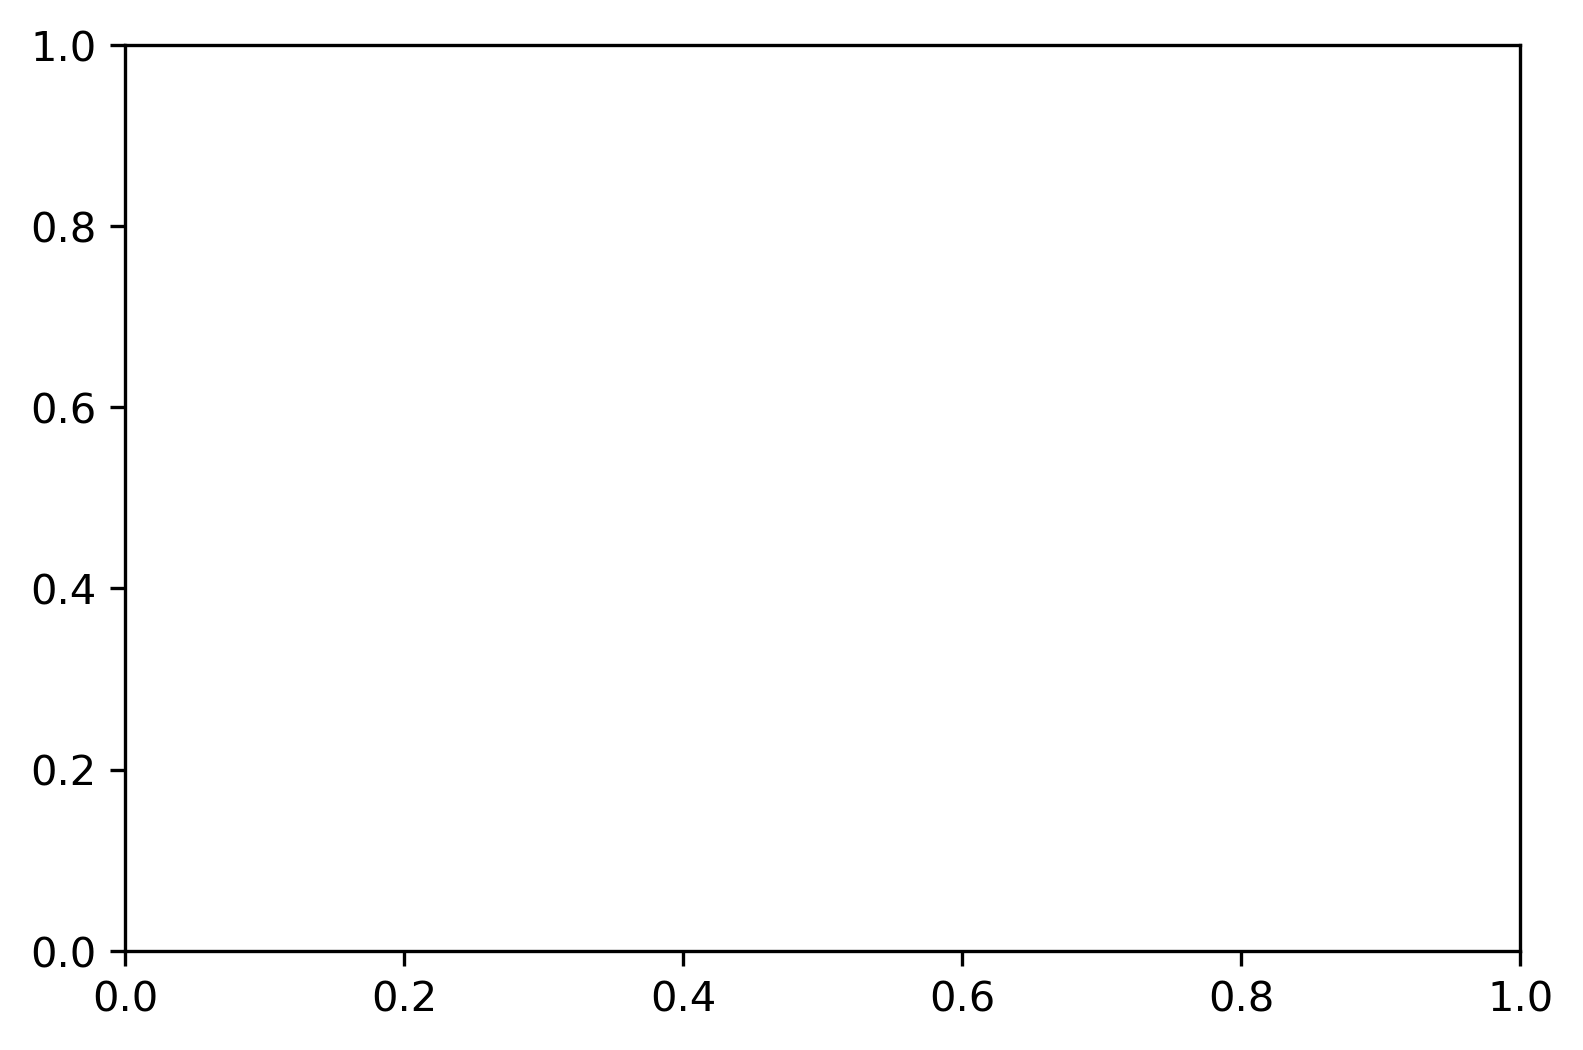

In [3]:
palette = plt.get_cmap('RdBu_r',Ncolor)

optpcolor = {"vmin":vmin, "vmax":vmax, "cmap" : palette, "alpha" : 1.}
# optpcolor = {"cmap" : palette}

if zps :
    opthatch = {'facecolor':'grey', 'alpha' : 0.8, 'interpolate':True, 'step' : 'mid'} # insist on steps
else :  
    opthatch = {'facecolor':'grey', 'alpha' : 0.8, 'interpolate':True} # insist on sco coordinate

levelsc = np.linspace(vmin,vmax, Ncolor//2 +1)

fig, ax = plt.subplots(dpi=dpi)
cf = ax.pcolormesh(xu, yuw, temp[0],**optpcolor)
c  = ax.contour(xt,yt,temp[0], levels = levelsc, colors='k', linewidths=0.5)

# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(cf,cax=cax)
cbar.set_label(r"Temperature (°C)")

ax.fill_between(xt[0,:], 2020, zht, **opthatch)
if bvp :
    ax.contour(xt,yt,rpot, levels = np.array((abp,1.-abp)), colors='white', linewidths=0.9)

titlezer = '%1.1fh/%1.1fh'%((0.)*tskip/2.,nT*tskip/2.) # because 30min sortie
titlezer += "\nmin = %2.1f °C   max = %2.1f °C" % (np.nanmin(temp[0]), np.nanmax(temp[0]))
ax.set_title(titlezer, fontsize = 12, y = 1.02)

ax.set_ylim(2020,0)
ax.set_yticks([0,500,1000,1500,2000])
ax.set_yticklabels(["0","500","1000","1500","2000"])
ax.set_ylabel("depth (m)")
ax.set_xlim(0,200)
ax.set_xticks([0,50, 100, 150, 200])
ax.set_xticklabels(["0","50","100","150","200"])
ax.set_xlabel("X (km)")
# ax.patch.set_color('0.8')

ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis = "y", which = 'both', width=1., labelsize = 10, pad = 5)
ax.tick_params(axis = 'x', which = 'both', width=1., labelsize = 10, pad = 10)
ax.tick_params(which='minor',length = 4)
ax.tick_params(which='major',length = 6)
plt.tight_layout()

def init():
    return(ax)

def animate(i):
    """Set the data for the ith iteration of the animation."""
    global c,cf, temp

    ax.collections = []
    cf = ax.pcolormesh(xu, yuw, temp[i], **optpcolor)
    c = ax.contour(xt,yt,temp[i], levels = levelsc,colors='k', linewidths=.5)
    #
    # ax.fill_between(xt[0,:], strait(xt[0,:]), ridge(xt[0,:]),**opthatch)
    ax.fill_between(xt[0,:], 2020, zht, **opthatch)
    if bvp :
        ax.contour(xt,yt,rpot, levels = np.array((abp,1.-abp)), colors='white', linewidths=0.5)
    #

    ptitle = '%1.1fh/%1.1fh'%((i+1)*tskip/2.,nT*tskip/2.) # because 30min sortie
    ptitle += "\nmin = %2.1f °C  max = %2.1f °C  " % (np.nanmin(temp[i]), np.nanmax(temp[i]))
    #sys.stdout.write(u"\u001b[1000D" + "processing movie [%3d/%3d]" % (i,nT-1))
    #sys.stdout.flush()
    ax.set_title(ptitle, fontsize = 12, y = 1.02)
    #
    return c, cf

if save:
    anim = animation.FuncAnimation(fig, animate, frames=nT, init_func=init, blit=False, repeat=False)
    writer = animation.writers['ffmpeg'](fps=2)
    anim.save('%s.mp4' % (psave), writer=writer, dpi=dpi)
    plt.close("all")
    print("\nsaving : %s" % psave)
else:
    anim = animation.FuncAnimation(fig, animate, frames=nT)
    plt.show()
